# Projekt wykonany przez: Kacper Kwaśnioch, Kacper Glazer
## Dane
Wykorzystane dane są z kaggle: https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us?select=PoliceKillingsUS.csv 

Dane składają się z informacji na temat osób zabitych przez policję w USA w ramach interwencji policyjnej. Całość składa się z 5 datasetów, w których możemy zaobserwować dane na temat wskaźniku ubóstwa, ukończenia szkoły średniej, mediany dochodu gospodarstw domowych, demografii rasowej oraz płciowej. Główny dataset skała się na dane osobowe osób zastrzelonych przez policję, imię, data śmierci, typ broni, czym i czy w ogóle była uzbrojona, wiek, rasa,miejsce zamieszkania. Dane zostały zbierane od 1 styczna 2015r. przez Washington Post, gazeta pozyskiwała dane ze stron internetowych organów ścigania, lokalnych raportów, mediów społecznościowych oraz poprzez monitorowanie niezależnych baz danych.

Jako zmienną **Y** obraliśmy **rase**, z której stworzyliśmy zmienną binarną wykorzystywana w modelach (pokrzywdzony był biały -1, jeżeli nie-0)

Za zmienne **X** posłużyły nam: age, date, signs_of_mental_illness, Median Income,poverty_rate, percent_completed_hs, share_white, share_black, share_native_american, share_asian, share_hispanic, threat_level, threat_level, gender
# Cel 

Wykorzystanie podejść:

*   propensity score weighting
*   Propensity score matching
*   Mass imputation





In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
import seaborn as sn
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import math
from statistics import variance
import warnings
warnings.filterwarnings('ignore')

In [83]:
df=pd.read_csv('https://raw.githubusercontent.com/whyme36/BI_2021/master/Fatal_Police_Shootings_in_the_US.csv')
df.head(5)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,Median Income,poverty_rate,percent_completed_hs,share_white,share_black,share_native_american,share_asian,share_hispanic
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,37072.0,28.6,80.1,78.9,0.8,3.7,1.1,19.2
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,65765.0,14.9,88.1,70.9,2.6,1.0,8.9,21.1
2,890,Phyllis Ilene Jepsen,02/10/15,shot,knife,55.0,F,W,Aloha,OR,True,other,Not fleeing,False,65765.0,14.9,88.1,70.9,2.6,1.0,8.9,21.1
3,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,45947.0,17.3,87.5,71.9,11.5,1.2,4.8,15.3
4,765,Nicholas Garner,22/08/15,shot,vehicle,26.0,M,W,Wichita,KS,False,attack,Car,False,45947.0,17.3,87.5,71.9,11.5,1.2,4.8,15.3


## Przetworzenie dancyh:

*   wyrzucenie niepotrzebnych kolumn
*   wyrzucenie wierszy bez określonej rasy
*   przetworzenie zmiennych jakościowych 
*   wypełnienie pustych komórek średnimi ilościowymi (np. age)
*   przekonwertowanie zmiennej date w liczbę 
*   zmianna zmiennej ,,race" na zmienną binarną (1-White,0-None White)

Po przetworzeniu nasze dane mają formaty liczbowe



In [44]:
def preprocessing(df):
    df = df.drop(['id', 'name', 'state', 'city', 'body_camera', 'flee','armed'], axis=1) #'armed'

    l_ch = []
    for e in df['threat_level']:
        if e == 'undetermined':
            l_ch.append('threat_level_undetermined')
        else:
            l_ch.append(e)
    df['threat_level'] = l_ch

    df = df[df['race'].notna()]
#     df = df[df['armed'].notna()]
    df = df.reset_index(drop=True)

    df['age'] = df['age'].fillna(df['age'].median())
    df['Median Income'] = df['Median Income'].fillna(df['Median Income'].median())
    cols = [ 'threat_level', 'manner_of_death', 'gender'] #'armed'
    for col in cols:
        dummy = pd.get_dummies(df[col])
        df = pd.concat([df, dummy], axis=1)
        df = df.drop(col,axis=1)
    df['signs_of_mental_illness'] = df['signs_of_mental_illness'].astype(int)
    ll =[datetime.strptime(element, '%d/%m/%y') for element in df['date']]
    ll2 = [e.strftime('%Y-%m-%d %H:%M:%S.%f') for e in ll]
    ll3 =[datetime.fromisoformat(element).timestamp() for element in ll2]
    df['date'] = ll3
    l_race  = []
    for e in df['race']:
        if e == 'W':
            l_race.append(1)
        else:
            l_race.append(0)
    df['race'] = l_race
    df = df.drop(['F', 'shot and Tasered'], axis=1)
    return df



## Korelacja

Sprawdzenie czy zienne ze sobą korelują, znależliśmy kolumny:


*   'F' i 'M"
*   'shot and Tasered' i 'shot'

reszte zmiennych uznaliśmy za potrzebne.



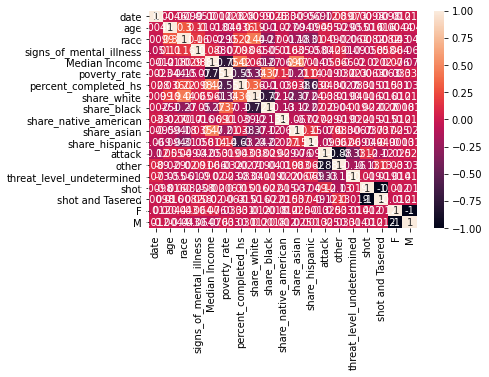

In [ ]:
corr_matrix=preprocessing(df).corr()
sn.heatmap(corr_matrix, annot=True)

## Utworzenie próby losowej i nielosowej
W naszym przypadku cała populacja liczy 2055 wierszy, z których tworzymy próby losowe.

nielosowa - jest to zmieniający się zakres od [0:400] elemtów [100:500] 

losowa- powstaje w wyniku próby warstwowej, za pośrednictwem zmiennej state



In [45]:
def losowa_nielosowa_split(df,i, losowa_wielkosc = 400):
  df_nielosowa = df[0+i:losowa_wielkosc+i]
  df_nielosowa = df_nielosowa.reset_index(drop=True)
  #Sprawdzanie ile wartosci znajduje się w populacji i ile chcemy przypisać do zbioru losowego
  import math
  dict_len = {}
  for e in df['state'].unique():
    lenn = math.ceil(len(df[df['state'] == e])/len(df)*losowa_wielkosc)
    dict_len[e] = lenn
  #obliczanie probability
  dict_prob = {}
  for e in dict_len.keys():
    prob = dict_len[e]/len(df[df['state'] == e])
    dict_prob[e] = prob
  #obliczanie wag
  dict_waga ={}
  for e in dict_prob.keys():
    waga = 1/dict_prob[e]
    dict_waga[e] = waga
  #tworzenie proby losowej
  proba_losowa = pd.DataFrame()
  for element in dict_len.keys():
    t = df[df['state'] == element].sample(n=int(dict_len[element]), replace=False, random_state = i)
    proba_losowa = pd.concat([proba_losowa, t])
  #dodawanie wag do proby losowej
  ll_wagi = []
  for e in proba_losowa['state']:
    waga = dict_waga[e]
    ll_wagi.append(waga)
  proba_losowa['waga'] = ll_wagi
  return proba_losowa, df_nielosowa

funkcja weightedMean oblicza średnią ważoną 

In [46]:
def weightedMean(Y,W,n) :
    sum = 0
    numWeight = 0
    i = 0
    while  i < n :     
        numWeight = numWeight + Y[i] * W[i]
        sum = sum + W[i]
        i = i + 1
    return round((numWeight / sum),4)

## Symulacja

Każde z podejść estymowaliśmy 100, zapisując wyniki do tablic.

Podejście **propensity score weighting** zostało zastosowane do modelu **RandomForestClassifier**..

Podejście **propensity score matching** zostało zastosowane do modelu  **CatBoostClassifier**.

Został również wyliczony model **naiwny**.

In [ ]:
Srednie_wazone_PSW=[]
Srednie_wazone_PSM=[]
Srednie_wazone_naiwny=[]
for i in range(100):
    #tworzymy próby losowe i nielosowe
    df_losowa, df_nielosowa=losowa_nielosowa_split(df,i)
    df_nielosowa=preprocessing(df_nielosowa)
    df_nielosowa['R']=1

    df_nielosowa_naiwny=df_nielosowa.copy()

    df_losowa=preprocessing(df_losowa)
    df_losowa_X=df_losowa.drop('race', axis=1)
    df_losowa_X['R']=0

    # tworzymy model z połączenia prób
    df_to_model = pd.concat([df_losowa_X, df_nielosowa])
    y = df_to_model['R']
    X = df_to_model.drop(['R', 'race', 'waga'], axis=1)
    model_rf = RandomForestClassifier(max_depth=1, random_state=2,verbose=False)
    model_rf.fit(X, y)
    
    #Propensity score weighting
    
    y_prob_rf = model_rf.predict_proba(X)
    df_to_model['prob']=[x[1] for x in y_prob_rf]
    df_nielosowa_PSW=df_to_model.loc[df_to_model['R']==1]
    df_nielosowa_PSW['waga']=round(1/df_nielosowa_PSW['prob'],2)
    
    PSW=weightedMean(df_nielosowa_PSW['race'],df_nielosowa_PSW['waga'],len(df_nielosowa_PSW))
    Srednie_wazone_PSW.append(PSW)

    #Naiwnego
    naiwny =df_nielosowa_naiwny['race'].mean()
    Srednie_wazone_naiwny.append(naiwny)

    #Propensity score matching
    model_cat = CatBoostClassifier(max_depth=8, random_state=2,verbose=False)
    model_cat.fit(X, y)
    y_prob_cat = model_cat.predict_proba(X)

    prob_list = []
    for e in y_prob_cat:
      prob_list.append(e[1])
    prob_list=[round(e,2) for e in prob_list]

    df_to_model_cat=df_to_model.copy()
    df_to_model_cat['prob'] = prob_list
    proba_losowa = df_to_model_cat[df_to_model_cat['race'].isna()]
    df_nielosowa = df_to_model_cat[df_to_model_cat['waga'].isna()]

    #tworze dwa dict jeden z prob z losowej jeden z nielosowej
    lis_min = []
    dist_los = proba_losowa['prob'].to_dict()
    dist_nlos = df_nielosowa['prob'].to_dict()

    #usupełniam matchujące do siebie prob z dwoch df, wynik dodaje do listy
    lis = []
    for index, row in proba_losowa.iterrows():
      for index_n, row_n in df_nielosowa.iterrows():
        if row['prob'] == row_n['prob']:
          lis.append((index, index_n))
    #Do kolejnej listy dodaję wagi znalezione w df_los
    lis2 = []
    for e in lis:
      indx = e[0]
      waga = proba_losowa[proba_losowa.index == indx]['waga'].tolist()
      waga = waga[0]
      lis2.append((waga,e[1]))

    #torze dict z kluczem jako index nielosowej, a value jako wagą matchującą
    lista_wag_n = {}
    for element in df_nielosowa.index:
      for tup in lis2:
        if element == tup[1]:
          lista_wag_n[element] = tup[0]
    #usuwam ze słownika początkowego znalezione wagi i indexy
    for e in lista_wag_n:
      dist_nlos.pop(e, None)

    # usupełniam brakujące elementy dobierając najbliższych sąsiadów z df_los
    ll_uzupelnienie = []
    for e in dist_nlos.keys():
      ll={}
      for e_l in dist_los.keys():
        val = abs(dist_nlos[e] - dist_los[e_l])
        ll[(e,e_l)]=val
      needed_val = min(ll.items(), key=lambda x: x[1])
      ll_uzupelnienie.append(needed_val[0])
    #sprawdzam jakie wagi miały dopasowane elementy z df_los
    ll_uzupelnienie_lis_2 = []
    for e in ll_uzupelnienie:
      indx = e[1]
      waga = proba_losowa[proba_losowa.index == indx]['waga'].tolist()
      waga = waga[0]
      ll_uzupelnienie_lis_2.append((waga,e[0]))
    #uzupełniam swój ostateczny dict dla nieloswej znalezionymi wagami
    for element in df_nielosowa.index:
      for tup in ll_uzupelnienie_lis_2:
        if element == tup[1]:
          lista_wag_n[element] = tup[0]

    df_nielosowa['waga'] = lista_wag_n.values()

    PSM=weightedMean(df_nielosowa['race'],df_nielosowa['waga'],len(df_nielosowa))
    Srednie_wazone_PSM.append(PSM)

    #Propensity score imputacja
    print(f'{i+1} z 100 został ukończony!')
    
    

## Wyliczenie średnich z tablic estymowanych wartości

In [70]:
print(f'Średnia naiwna: {round(np.array(Srednie_wazone_naiwny).mean(),4)}')
print(f'Średnia PSW: {round(np.array(Srednie_wazone_PSW).mean(),4)}')
print(f'Średnia PSM: {round(np.array(Srednie_wazone_PSM).mean(),4)}')
print(f'Średnia prawdziwa: {round(df_population_mean,4)}')


Średnia naiwna: 0.3896
Średnia PSW: 0.4018
Średnia PSM: 0.3902
Średnia prawdziwa: 0.4939


## BIAS/VAR/MSE

In [68]:
df_population_mean=preprocessing(df)['race'].mean()
def BiasVarMSE(Srednie_wazone_modelu,Y,nazwa_podejscia):
  bias=round(np.array(Srednie_wazone_modelu).mean(),4)-df_population_mean
  var = variance(Y)
  MSE=bias**2+var
  return nazwa_podejscia,bias,var,MSE

In [59]:
Wyniki = pd.DataFrame(np.array([BiasVarMSE(Srednie_wazone_PSW,df_nielosowa_PSW['race'],'PSW'), BiasVarMSE(Srednie_wazone_PSM,df_nielosowa['race'],'PSM'), BiasVarMSE(Srednie_wazone_naiwny,df_nielosowa_naiwny['race'],'Naiwny')]),
                   columns=['name','BIAS', 'VAR', 'MSE'])
Wyniki

,name,BIAS,VAR,MSE
0,PSW,-0.09211727493917277,0.24168270944741535,0.2501683017896345
1,PSM,-0.10371727493917277,0.24168270944741535,0.2524399825682233
2,Naiwny,-0.10431727493917275,0.24168270944741535,0.2525648032981503




1.   Obciążenie jak i samo MSE jest największe dla estymatora naiwnego
2.   


